In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
     

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/Users/ohheungchan/workspace/AI_Study/Paperwork/human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/Users/ohheungchan/workspace/AI_Study/Paperwork/human+activity+recognition+using+smartphones/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot


In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:

print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)
     

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)
     

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:

unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:

X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy
     

In [8]:

print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [9]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)
     


In [10]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]


In [11]:

from tensorflow.keras.layers import GRU

# Model 1
model = Sequential()
model.add(GRU(128, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
     

Metal device set to: Apple M2 Pro


2024-03-20 00:03:09.668843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-20 00:03:09.669145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               53376     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 70,662
Trainable params: 70,662
Non-trainable params: 0
_________________________________________________________________


In [12]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-20 00:03:18.072405: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-20 00:03:18.935608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:03:19.069657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:03:36.827704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 1.3029 - accuracy: 0.4674

2024-03-20 00:04:07.857400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:04:07.907116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 77s 873ms/step - loss: 1.3029 - accuracy: 0.4674 - val_loss: 1.0616 - val_accuracy: 0.5295
Epoch 2/10
58/58 [==============================] - 4s 61ms/step - loss: 0.9855 - accuracy: 0.5820 - val_loss: 0.8606 - val_accuracy: 0.6482
Epoch 3/10
58/58 [==============================] - 3s 60ms/step - loss: 0.8753 - accuracy: 0.6432 - val_loss: 0.7981 - val_accuracy: 0.6632
Epoch 4/10
58/58 [==============================] - 3s 58ms/step - loss: 0.7205 - accuracy: 0.6979 - val_loss: 0.6476 - val_accuracy: 0.7248
Epoch 5/10
58/58 [==============================] - 4s 62ms/step - loss: 0.6493 - accuracy: 0.7243 - val_loss: 0.5778 - val_accuracy: 0.7489
Epoch 6/10
58/58 [==============================] - 4s 61ms/step - loss: 0.5541 - accuracy: 0.7750 - val_loss: 0.4950 - val_accuracy: 0.8024
Epoch 7/10
58/58 [==============================] - 3s 57ms/step - loss: 0.4911 - accuracy: 0.8013 - val_loss: 0.4791 - val_accuracy: 0.8024
Epoch 8/10
58/58 [====

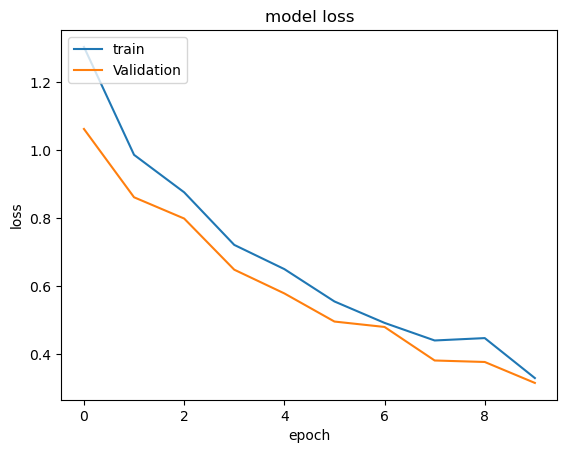

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

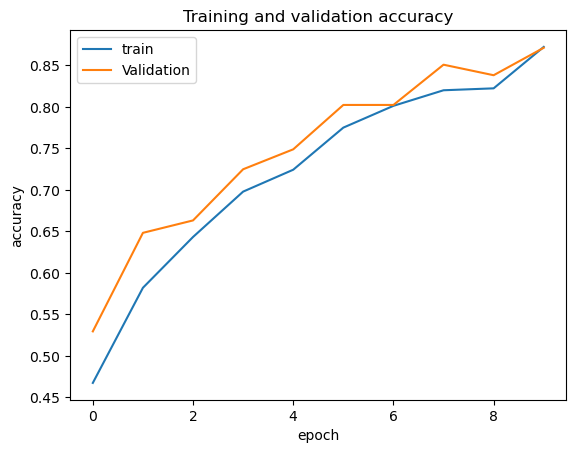

In [14]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-20 00:06:11.801847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:06:11.843379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 30s 184ms/step
[[428   3  65   0   0   0]
 [ 18 365  87   1   0   0]
 [ 63   9 348   0   0   0]
 [  8  18   3 292 170   0]
 [ 39   1   1  29 462   0]
 [  0  27   0  14   0 496]]
0.8113335595520869
0.8107478338932997
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       496
           1       0.86      0.77      0.82       471
           2       0.69      0.83      0.75       420
           3       0.87      0.59      0.71       491
           4       0.73      0.87      0.79       532
           5       1.00      0.92      0.96       537

    accuracy                           0.81      2947
   macro avg       0.82      0.81      0.81      2947
weighted avg       0.82      0.81      0.81      2947



<Axes: >

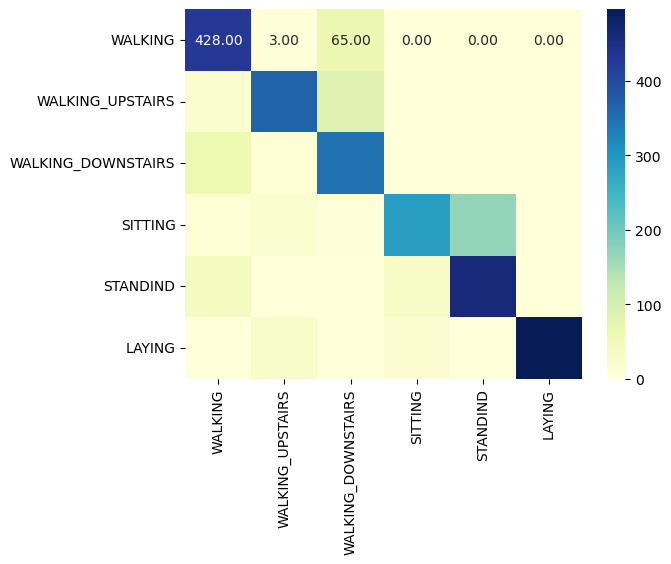

In [15]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU2

In [17]:

#model 2
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
     

SyntaxError: invalid syntax (1843211268.py, line 1)

In [18]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-20 00:07:57.206869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:07:57.418404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:08:10.809976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:08:24.565793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:08:29.981978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 1.2487 - accuracy: 0.4752

2024-03-20 00:09:18.892443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:09:18.967577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:09:32.392918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 139s 2s/step - loss: 1.2487 - accuracy: 0.4752 - val_loss: 1.0854 - val_accuracy: 0.5304
Epoch 2/10
58/58 [==============================] - 7s 113ms/step - loss: 1.0181 - accuracy: 0.5468 - val_loss: 0.8296 - val_accuracy: 0.6034
Epoch 3/10
58/58 [==============================] - 6s 112ms/step - loss: 0.7875 - accuracy: 0.6232 - val_loss: 0.6914 - val_accuracy: 0.6886
Epoch 4/10
58/58 [==============================] - 7s 113ms/step - loss: 0.6305 - accuracy: 0.7108 - val_loss: 0.5840 - val_accuracy: 0.7199
Epoch 5/10
58/58 [==============================] - 6s 111ms/step - loss: 0.5662 - accuracy: 0.7379 - val_loss: 0.5610 - val_accuracy: 0.7557
Epoch 6/10
58/58 [==============================] - 7s 113ms/step - loss: 0.4831 - accuracy: 0.7893 - val_loss: 0.4900 - val_accuracy: 0.7856
Epoch 7/10
58/58 [==============================] - 6s 111ms/step - loss: 0.4949 - accuracy: 0.7845 - val_loss: 0.4424 - val_accuracy: 0.8073
Epoch 8/10
58/58 [

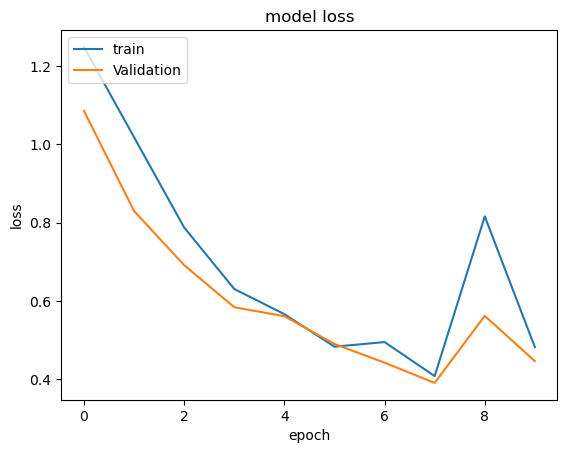

In [19]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

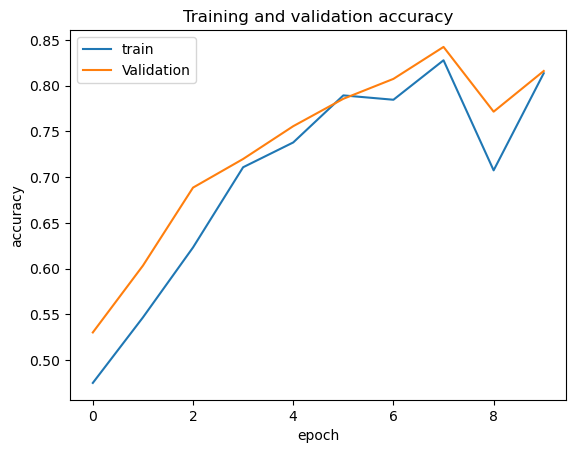

In [20]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

2024-03-20 00:11:42.805428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:11:42.878749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:11:56.431129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 59s 342ms/step
[[433  55   6   0   2   0]
 [314 137  19   0   1   0]
 [ 55 110 255   0   0   0]
 [ 23   1   5 264 197   1]
 [ 62   0   0  23 447   0]
 [  0   0   0   0   0 537]]
0.7034272141160502
0.6970724869265641
              precision    recall  f1-score   support

           0       0.49      0.87      0.63       496
           1       0.45      0.29      0.35       471
           2       0.89      0.61      0.72       420
           3       0.92      0.54      0.68       491
           4       0.69      0.84      0.76       532
           5       1.00      1.00      1.00       537

    accuracy                           0.70      2947
   macro avg       0.74      0.69      0.69      2947
weighted avg       0.74      0.70      0.70      2947



<Axes: >

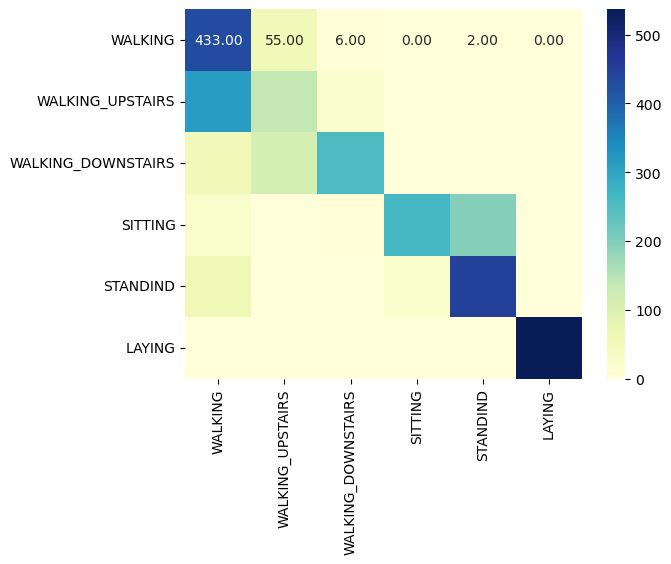

In [21]:


from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [22]:

# Model 3
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 128, 128)          53376     
                                                                 
 dropout_3 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_4 (GRU)                 (None, 128, 128)          99072     
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [23]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-20 00:12:59.466984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:12:59.765612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:13:13.268766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:13:26.578117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:13:40.265121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:13:45.737581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:13:51.199029: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - ETA: 0s - loss: 1.2180 - accuracy: 0.4706

2024-03-20 00:15:02.577538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:15:02.681878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:15:16.432228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:15:30.008957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 208s 3s/step - loss: 1.2180 - accuracy: 0.4706 - val_loss: 1.0582 - val_accuracy: 0.5281
Epoch 2/10
58/58 [==============================] - 9s 162ms/step - loss: 1.0007 - accuracy: 0.5611 - val_loss: 0.8511 - val_accuracy: 0.6333
Epoch 3/10
58/58 [==============================] - 9s 162ms/step - loss: 0.9760 - accuracy: 0.5817 - val_loss: 0.8506 - val_accuracy: 0.6265
Epoch 4/10
58/58 [==============================] - 10s 165ms/step - loss: 1.2315 - accuracy: 0.4827 - val_loss: 1.4264 - val_accuracy: 0.3604
Epoch 5/10
58/58 [==============================] - 9s 163ms/step - loss: 1.1221 - accuracy: 0.5098 - val_loss: 0.9187 - val_accuracy: 0.5653
Epoch 6/10
58/58 [==============================] - 9s 161ms/step - loss: 1.1299 - accuracy: 0.4966 - val_loss: 1.1340 - val_accuracy: 0.4977
Epoch 7/10
58/58 [==============================] - 10s 166ms/step - loss: 1.1090 - accuracy: 0.5026 - val_loss: 1.1281 - val_accuracy: 0.5014
Epoch 8/10
58/58

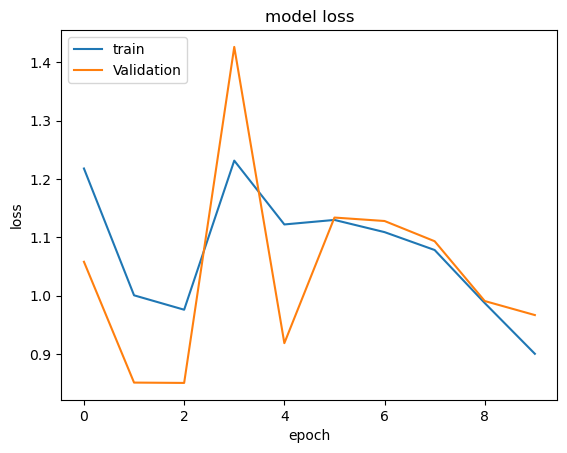

In [24]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

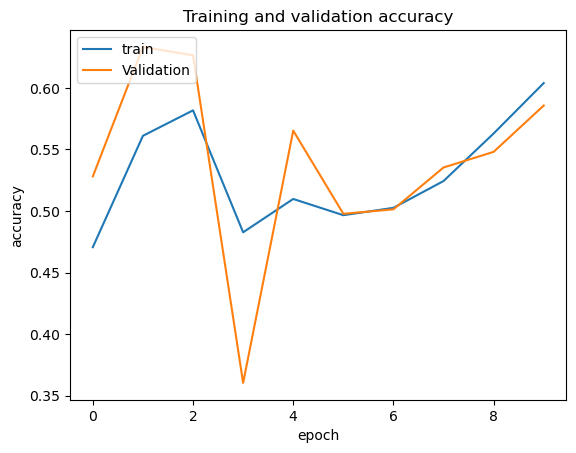

In [25]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-20 00:18:47.782161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:18:47.871116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:19:01.458633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:19:14.850425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 87s 498ms/step
[[194   6  73  31 192   0]
 [248  45  73   6  99   0]
 [151   6 110  23 130   0]
 [  8   0   3 385  95   0]
 [ 14   0   3 116 399   0]
 [  0   4   2   0   0 531]]
0.5646420088225313
0.5343550834238904
              precision    recall  f1-score   support

           0       0.32      0.39      0.35       496
           1       0.74      0.10      0.17       471
           2       0.42      0.26      0.32       420
           3       0.69      0.78      0.73       491
           4       0.44      0.75      0.55       532
           5       1.00      0.99      0.99       537

    accuracy                           0.56      2947
   macro avg       0.60      0.55      0.52      2947
weighted avg       0.61      0.56      0.53      2947



<Axes: >

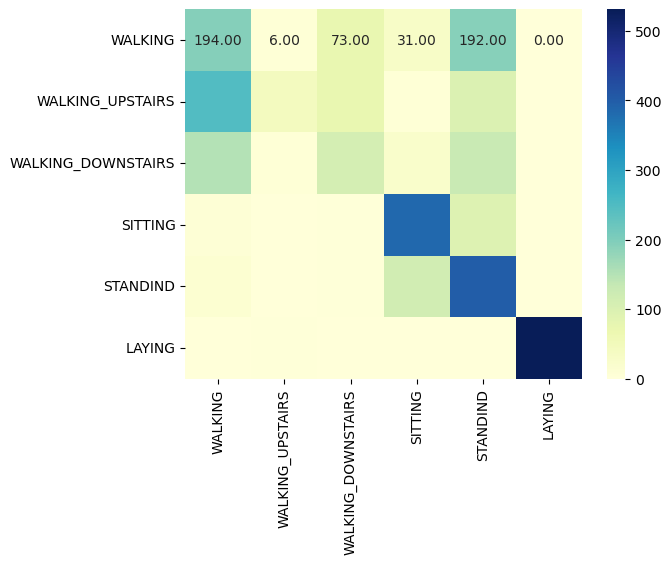

In [26]:


from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [27]:

# Model 4
model = Sequential()
model.add(GRU(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 128, 128)          53376     
                                                                 
 dropout_6 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_7 (GRU)                 (None, 128, 128)          99072     
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_8 (GRU)                 (None, 128, 128)          99072     
                                                                 
 dropout_8 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_9 (GRU)                 (None, 128)              

In [28]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
   

Epoch 1/10


2024-03-20 00:20:37.065990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:20:37.476125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:20:51.168345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:21:04.994045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:21:19.052592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:21:32.478821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:21:37.952792: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - ETA: 0s - loss: 1.2194 - accuracy: 0.4754

2024-03-20 00:23:20.801879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:23:20.932403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:23:34.705174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:23:48.170598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:24:01.381633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 276s 3s/step - loss: 1.2194 - accuracy: 0.4754 - val_loss: 1.0535 - val_accuracy: 0.5317
Epoch 2/10
58/58 [==============================] - 12s 204ms/step - loss: 0.9913 - accuracy: 0.5585 - val_loss: 1.2610 - val_accuracy: 0.4764
Epoch 3/10
58/58 [==============================] - 12s 203ms/step - loss: 0.7816 - accuracy: 0.6334 - val_loss: 0.6563 - val_accuracy: 0.6995
Epoch 4/10
58/58 [==============================] - 12s 204ms/step - loss: 0.6148 - accuracy: 0.7193 - val_loss: 0.5191 - val_accuracy: 0.7856
Epoch 5/10
58/58 [==============================] - 12s 203ms/step - loss: 0.5224 - accuracy: 0.7592 - val_loss: 0.4185 - val_accuracy: 0.8268
Epoch 6/10
58/58 [==============================] - 12s 205ms/step - loss: 0.4162 - accuracy: 0.8171 - val_loss: 0.3384 - val_accuracy: 0.8445
Epoch 7/10
58/58 [==============================] - 12s 204ms/step - loss: 0.3408 - accuracy: 0.8560 - val_loss: 0.2562 - val_accuracy: 0.8889
Epoch 8/10
5

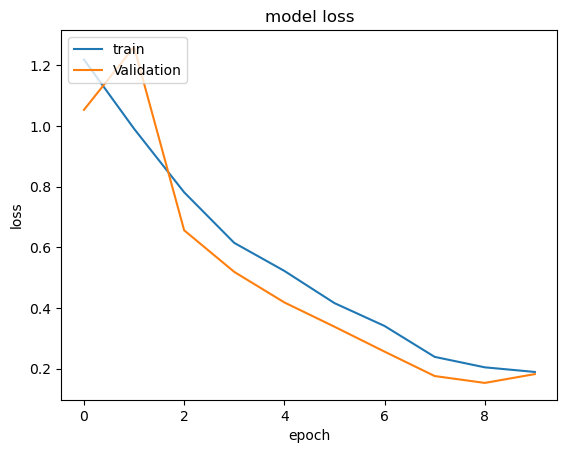

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

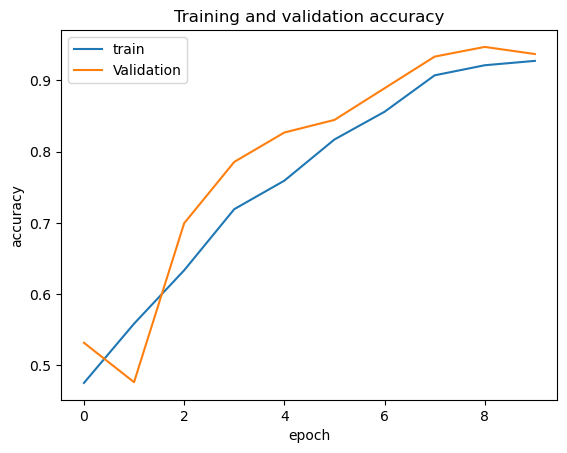

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

2024-03-20 00:27:33.397959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:27:33.530888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:27:47.022683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:28:00.552555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:28:13.748990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 118s 690ms/step
[[461   0  35   0   0   0]
 [ 59 369  42   0   1   0]
 [  4  18 398   0   0   0]
 [  1   1   0 381 108   0]
 [  2   0   0  88 442   0]
 [  0  27   0   0   0 510]]
0.8690193417034272
0.8686880651740686
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       496
           1       0.89      0.78      0.83       471
           2       0.84      0.95      0.89       420
           3       0.81      0.78      0.79       491
           4       0.80      0.83      0.82       532
           5       1.00      0.95      0.97       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.87      0.87      0.87      2947



<Axes: >

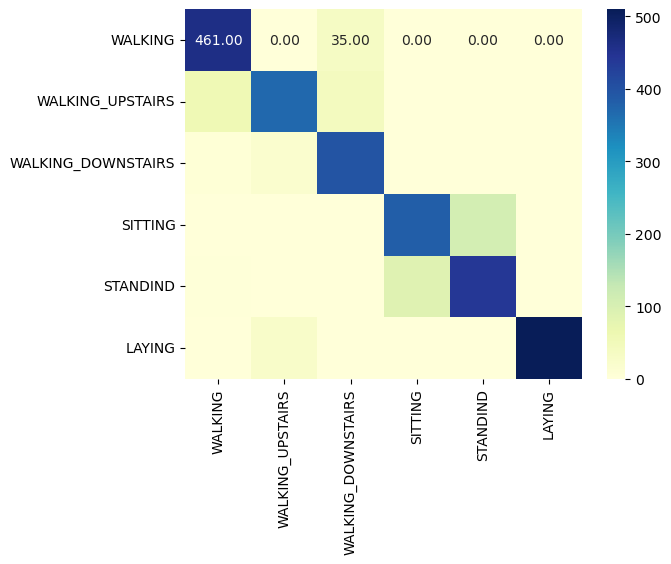

In [31]:

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')
     

In [32]:


# Model 1
model = Sequential()
model.add(GRU(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 128, 128)          53376     
                                                                 
 dropout_10 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_11 (GRU)                (None, 128, 128)          99072     
                                                                 
 dropout_11 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_12 (GRU)                (None, 128, 128)          99072     
                                                                 
 dropout_12 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_13 (GRU)                (None, 128, 128)         

In [34]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-20 00:32:22.540281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:32:23.019773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:32:36.281104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:32:49.475062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:33:02.766277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:33:15.878175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:33:29.302059: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - ETA: 0s - loss: 1.2544 - accuracy: 0.4538

2024-03-20 00:35:43.609064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:35:43.769021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:35:56.935383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:36:10.349198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:36:23.603022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:36:36.772822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 339s 4s/step - loss: 1.2544 - accuracy: 0.4538 - val_loss: 1.0749 - val_accuracy: 0.5408
Epoch 2/10
58/58 [==============================] - 15s 250ms/step - loss: 1.0377 - accuracy: 0.5462 - val_loss: 0.9027 - val_accuracy: 0.6102
Epoch 3/10
58/58 [==============================] - 14s 246ms/step - loss: 0.8317 - accuracy: 0.6390 - val_loss: 0.7507 - val_accuracy: 0.6782
Epoch 4/10
58/58 [==============================] - 14s 247ms/step - loss: 0.7839 - accuracy: 0.6431 - val_loss: 0.7310 - val_accuracy: 0.6673
Epoch 5/10
58/58 [==============================] - 14s 248ms/step - loss: 0.5977 - accuracy: 0.7337 - val_loss: 0.5120 - val_accuracy: 0.7797
Epoch 6/10
58/58 [==============================] - 14s 249ms/step - loss: 0.5075 - accuracy: 0.7826 - val_loss: 0.5148 - val_accuracy: 0.7860
Epoch 7/10
58/58 [==============================] - 15s 251ms/step - loss: 0.4949 - accuracy: 0.7950 - val_loss: 0.4847 - val_accuracy: 0.7987
Epoch 8/10
5

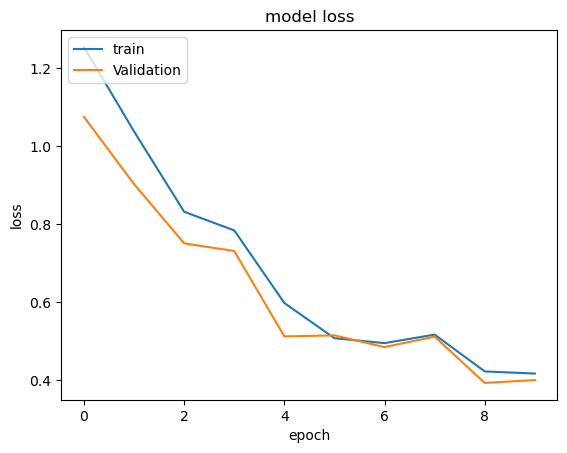

In [36]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

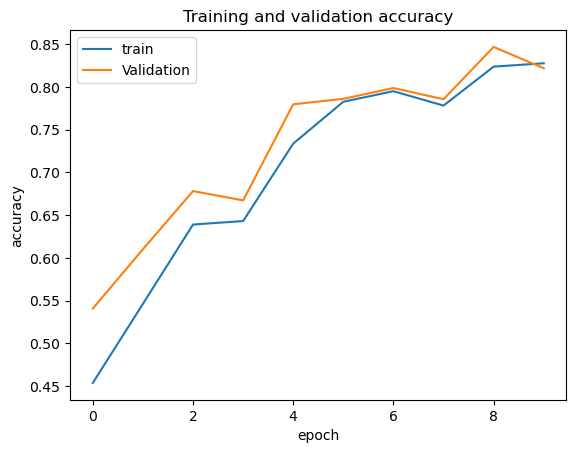

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

2024-03-20 00:44:08.259601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:44:08.414560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:44:21.791182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:44:35.117929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:44:48.311625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-20 00:45:01.651047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 145s 833ms/step
[[442   6  46   0   2   0]
 [112  72 285   0   2   0]
 [ 53   8 359   0   0   0]
 [ 21   3   0 391  76   0]
 [ 18   1   2  89 422   0]
 [  0   1   0   0   0 536]]
0.7539871055310485
0.7268364385036814
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       496
           1       0.79      0.15      0.26       471
           2       0.52      0.85      0.65       420
           3       0.81      0.80      0.81       491
           4       0.84      0.79      0.82       532
           5       1.00      1.00      1.00       537

    accuracy                           0.75      2947
   macro avg       0.77      0.75      0.72      2947
weighted avg       0.79      0.75      0.73      2947



<Axes: >

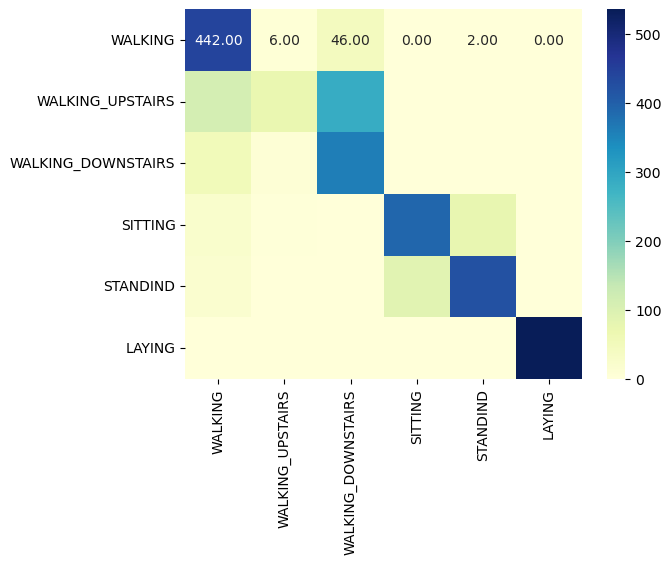

In [37]:

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')